# Deep Learning: Assignment 1. Cat, Dog, Car or Bike?

**Dataset**: You are provided with a dataset which contains more than 3000 pictures with either a cat, a dog, a motorbike or a car. The dataset has already been split in training(1675), test and validation sets. Your task is to build and train a CNN which is able to recognize which object is depicted in the picture. To this end, you must use and change the code we presented during our tutorial on classifying cat and dog images. You should copy and unzip the dataset in your local directory (do not change the name of the directory), namely the same directory where this jupyter notebook is going to be stored.

**Pytorch.** The deep learning code should be Pytorch. You can find the documentation for Pytorch at the following address https://pytorch.org/tutorials/

**What to submit:** You should post on moodle this jupyter notebook filled will all the answers to the questions, the Python code and the plots. Do not change any part of the code that is provided to you, unless explicitly asked. You should also post on moodle the model for question 5 (name of the model "modelQ5.h1"). The answers to the questions should be provided below at the end of the notebook. Important: For each question you will get 0 points if the code or any of the plots are missing or the code is not correct.

**GPU Farm:** You will have access to the HKU GPU farm to do this assignment. Additional info on how to use it is contained in a separate document provided with the assignement. Please use this only for questions 4 and 5.

**Image Size**. You should use image size 32x32 for the first three questions. You can use higher resolutions for questions 4 and 5. We kindly ask you to use your machine whenever possible, in order to avoid the GPU farm to be overwhelmed.

If you have any questions, you can join the WhatsApp group to discuss together. Also Assignment1 tutorial video link will be available in this group. https://chat.whatsapp.com/GPVWwxFa1NX1ci3ktCnMww


## How to Use GPU Farm.

For **windows** users to use ssh to the GPU Farm, you should download **MobaXterm** first. For mac and linux users, you can use the terminal directly.

1.Connect to HKU Network via HKU VPN with your HKU Portal account
https://its.hku.hk/services/network-connectivity/hkuvpn/

 

2.The instructions for Accessing GPU Farm are on this page:
https://www.cs.hku.hk/gpu-farm/quickstart

For GPU Farm Phase 1, click the following link and login with your CS computing account.
https://intranet.cs.hku.hk/gpufarm_acct/


But actually, GPU Farm 1 is not stable. Alternatively, we strongly recommend you use GPU Farm Phase 2, you may try with your HKU Portal account.
https://intranet.cs.hku.hk/gpufarm_acct_cas/ for application.

## Install.md
You should download and install **anaconda** first. To create the environment in Anaconda prompt, enter the following command (without the $ symbol). 

In [ ]:
!conda create -n hku_dasc7606 python=3.8
!conda activate hku_dasc7606
!pip install torch==2.1.0 torchvision==0.16.0
!pip install matplotlib
!pip install jupyter

## Import Library and define some functions

In [1]:
import sys
sys.path.append(".")

import random
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def set_seed(seed=1):  
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def plot_loss_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list):

    plt.figure(figsize=(10, 6))

    # train loss
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss')
    # val loss
    plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # train acc
    plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc')
    # val acc
    plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

## Prepare the dataset and the dataloader
We have prepared the dataset for you. You should download it in:
https://drive.google.com/file/d/1wTuQyTtHCQq-xawNkIUEWT-ga1FrVOrj/view?usp=sharing

Unzip the file and the folder structure is shown as:
```
Assign1
├── Skeleton_Assignment1_Pytorch.ipynb
├── cat_dog_car_bike
│   ├── train
│   ├── val
│   ├── test
```

In [2]:
####### Define the Dataset.
class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):

        self.label_name = {"c0": 0, "c1": 1, "c2": 2, "c3": 3}
        self.data_info = self.get_img_info(data_dir)  # data_info stores all image paths and tags, and reads samples through index in DataLoader
        self.transform = transform

    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB')     # 0~255

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.data_info)

    def get_img_info(self, data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            # categories
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

                # images
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = self.label_name[sub_dir]
                    data_info.append((path_img, int(label)))

        return data_info

def build_dataloader(INPUT_SIZE, BATCH_SIZE):
    # dataset path
    split_dir = os.path.join("/Users/mac/Documents/code/deep learning/Assign1/cat_dog_car_bike")
    train_dir = os.path.join(split_dir, "train")
    valid_dir = os.path.join(split_dir, "val")
    
    # dataset mean and std
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    
    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.RandomCrop(INPUT_SIZE, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])
    valid_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])
    
    # Build MyDataset instance
    train_data = MyDataset(data_dir=train_dir, transform=train_transform)
    valid_data = MyDataset(data_dir=valid_dir, transform=valid_transform)
    
    # Build DataLoder
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE)
    
    return train_loader, valid_loader

## Training Function

In [12]:
def train_model(model, optimizer, criterion, train_loader, epoch, max_epoch):

    loss_train = 0.
    correct = 0.
    total = 0.

    model.train()
    for i, data in enumerate(train_loader):

        # forward
        inputs, labels = data
        outputs = model(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        loss_train += loss.item()

        # update parameters
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

    
    loss_train_epoch = loss_train / len(train_loader)

    print("Train：Epoch[{:0>3}/{:0>3}] Iterations[{:0>3}/{:0>3}] Loss：{:.4f} Accuracy：{:.2%}".format(
        epoch, max_epoch, i+1, len(train_loader), loss_train_epoch, correct / total))

    train_loss = loss_train_epoch
    train_acc = correct / total

    return  train_loss, train_acc


def valid_model(model, criterion, valid_loader, epoch, max_epoch):

    correct_val = 0.
    total_val = 0.
    loss_val = 0.
    model.eval()
    with torch.no_grad():
        for j, data in enumerate(valid_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).squeeze().sum().numpy()

            loss_val += loss.item()

    # print val loss
    loss_val_epoch = loss_val / len(valid_loader)
    print("Val：Epoch[{:0>3}/{:0>3}] Iterations[{:0>3}/{:0>3}] Loss：{:.4f} Accuracy：{:.2%}".format(
        epoch, max_epoch, j+1, len(valid_loader), loss_val_epoch, correct_val / total_val))

    val_loss = loss_val_epoch
    val_acc = correct_val / total_val
    return  val_loss, val_acc

def main(model, LR, INPUT_SIZE=32, BATCH_SIZE=20, MAX_EPOCH=30):

    val_interval = 1
    
    ################# Build the Dataloader.
    train_loader,  valid_loader = build_dataloader(INPUT_SIZE, BATCH_SIZE)
    
    ################# Bulid Model.
    criterion = nn.CrossEntropyLoss()                                       # loss
    optimizer = optim.RMSprop(model.parameters(), lr=LR)                    # optimizer
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # scheduler
    
    ################# Plot the loss and acc.
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    ################# Main training process.
    for epoch in range(MAX_EPOCH):
        train_loss, train_acc = train_model(model, optimizer, criterion, train_loader, epoch, MAX_EPOCH)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
    
        if (epoch + 1) % val_interval == 0:
            val_loss, val_acc = valid_model(model, criterion, valid_loader, epoch, MAX_EPOCH)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
    
    plot_loss_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list)


## Question 1 (CNN Architecture) 

Define a CNN architecture with the following layers stacked on top of each other in the following order:
1. A convolutional layer with 32 3 × 3 filters. 
2. A max Pooling Layer with size 2 × 2.
3. A convolutional layer with 64 3 × 3 filters. 
4. A max Pooling Layer with size 2 × 2.
5. A convolutional layer with 128 3 × 3 filters. 
6. A max Pooling Layer with size 2 × 2.
7. A convolutional layer with 128 3 × 3 filters. 
7. A max Pooling Layer with size 2 × 2.
9. A dense layer with 512 units.
10. A dense layer with k units and softmax (aka cross entropy) loss function.

Use the sigmoid activation function for all layers but the last one which uses the softmax. Use default values for the parameters which are not specified above.

a) <font color=Red>[5pts]</font> Determine the right value for k and write the value for k you use at the end of the notebook. Write the code to solve a) in the cell below


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Sequential(            
            nn.Conv2d(3,32,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Complete the init
        self.conv1 = nn.Sequential(
            nn.Conv2d(32,64,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128,128,(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc0 = nn.Sequential(
            nn.Linear(128*2*2, 512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 4),
        )


    def forward(self,x):
        # Complete the forward
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc0(x)
        x = self.fc1(x)
        
        return x

b) <font color=Red>[5pts]</font> The architecture defined above cannot be built because of an error. You should fix such an error **without changing the number of convolutional, pooling or dense layers, the number of filters, the size of the filters, or the number of units**. Write at the end of the notebook which strategy did you use and write the code to solve b) in the cell below:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Sequential(            
            nn.Conv2d(3,32,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Complete the init
        self.conv1 = nn.Sequential(
            nn.Conv2d(32,64,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128,128,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc0 = nn.Sequential(
            nn.Linear(128*2*2, 512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 4),
        )

    def forward(self,x):
        # Complete the forward
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc0(x)
        x = self.fc1(x)
        return x

## Question 2 (Training a small CNN from scratch)

We are now considering a different CNN architecture specified in the code below. **Fill the missing parts (there is a comment (#) specifying which parts must be filled)**. After that, you should train such a CNN using the following values for the parameters:

- loss function = crossentropy;
- optimizer RMSprop with learning rate = 0.1;
- metrics = accuracy;
- Batch size for the training/validation generators = 20; 
- epochs = 30.

*Write your codes below and some answers at the end of the notebook again. Plot both the training/validation accuracy and training/validation as a function of the epochs. Report the plots below:*

Train：Epoch[000/030] Iterations[084/084] Loss：1.3894 Accuracy：21.01%
Val：Epoch[000/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[001/030] Iterations[084/084] Loss：1.3895 Accuracy：21.01%
Val：Epoch[001/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[002/030] Iterations[084/084] Loss：1.3896 Accuracy：21.01%
Val：Epoch[002/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[003/030] Iterations[084/084] Loss：1.3896 Accuracy：21.01%
Val：Epoch[003/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[004/030] Iterations[084/084] Loss：1.3896 Accuracy：21.01%
Val：Epoch[004/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[005/030] Iterations[084/084] Loss：1.3895 Accuracy：21.01%
Val：Epoch[005/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[006/030] Iterations[084/084] Loss：1.3893 Accuracy：21.01%
Val：Epoch[006/030] Iterations[042/042] Loss：1.3913 Accuracy：20.96%
Train：Epoch[007/030] Iterations[084/084] Loss：1.

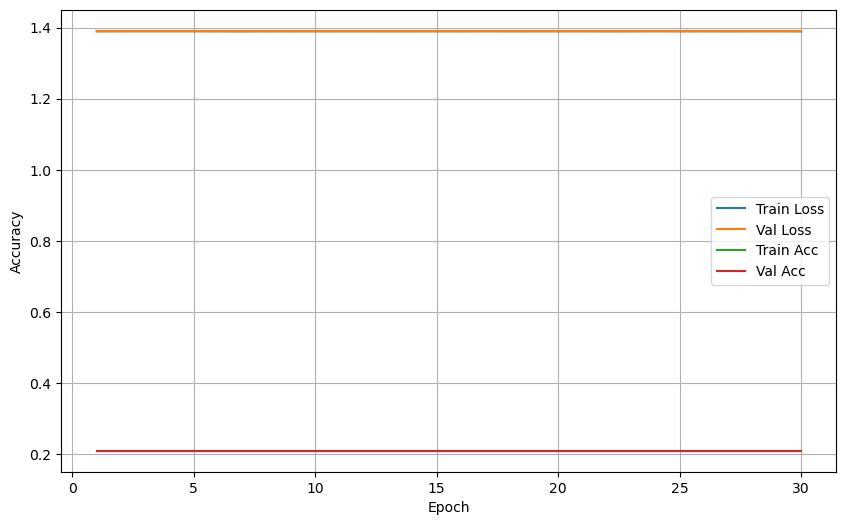

In [5]:
LR = 1e-15
model = Net()
main(model, LR)

a) <font color=Red>[5pts]</font> What is the main problem for your model?

1. Overfitting
2. Underfitting

b) <font color=Red>[5pts]</font> **Without changing the learning rate**, change one hyperparameter so as to improve the accuracy. Which hyperparameters did you change? 

*Hint: Only change the model part and do not need to run the training in this part.*

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Sequential(            
            nn.Conv2d(3,32,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Complete the init
        self.conv1 = nn.Sequential(
            nn.Conv2d(32,64,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128,128,(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc0 = nn.Sequential(
            nn.Linear(128*2*2, 512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 4),
        )

    def forward(self,x):
        # Complete the forward
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc0(x)
        x = self.fc1(x)
        return x

## Question 3 (Optimize the learning rate) 

a)<font color=Red>[10pts]</font> Determine an interval [a,b] of possible values for the learning rate, which is “wide enough”. In particular, you should try to guarantee that **your interval contains an optimal value for the learning rate**. At the same time the interval that you provided should not be too wide, due to efficiency reasons. In particular, your interval [a,b] should be such that $\frac{b}{a} \leq 10$.

b)<font color=Red>[15pts]</font> Provide a "good" value for the learning rate. In particular, the valid accuracy should become larger than 75% within 30 epochs. 

*Write your codes below and some answers at the end of the notebook again. Plot both the training/validation accuracy and training/validation as a function of the epochs. Report the plots below:*


Train：Epoch[000/030] Iterations[084/084] Loss：49.3822 Accuracy：33.49%
Val：Epoch[000/030] Iterations[042/042] Loss：1.1286 Accuracy：43.59%
Train：Epoch[001/030] Iterations[084/084] Loss：1.0781 Accuracy：50.03%
Val：Epoch[001/030] Iterations[042/042] Loss：0.9436 Accuracy：58.80%
Train：Epoch[002/030] Iterations[084/084] Loss：0.9032 Accuracy：60.96%
Val：Epoch[002/030] Iterations[042/042] Loss：0.9364 Accuracy：60.48%
Train：Epoch[003/030] Iterations[084/084] Loss：0.7780 Accuracy：65.19%
Val：Epoch[003/030] Iterations[042/042] Loss：0.9331 Accuracy：57.84%
Train：Epoch[004/030] Iterations[084/084] Loss：0.7431 Accuracy：66.75%
Val：Epoch[004/030] Iterations[042/042] Loss：0.6358 Accuracy：71.62%
Train：Epoch[005/030] Iterations[084/084] Loss：0.6803 Accuracy：70.45%
Val：Epoch[005/030] Iterations[042/042] Loss：0.6555 Accuracy：71.02%
Train：Epoch[006/030] Iterations[084/084] Loss：0.6536 Accuracy：72.42%
Val：Epoch[006/030] Iterations[042/042] Loss：0.5978 Accuracy：74.01%
Train：Epoch[007/030] Iterations[084/084] Loss：0

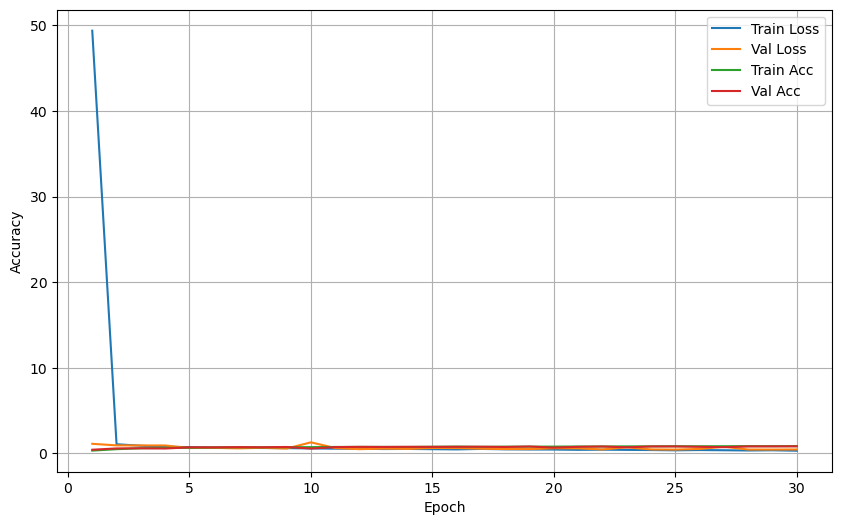

In [7]:
LR = 0.003
model = Net()
main(model, LR)


## Question 4 (Transfer Learning) <font color=Red>[25pts]</font>

Use the VGG16 as feature extractor with data augmentation (i.e. remove the top layer and freeze the VGGnet). You should try to achieve a **validation accuracy of at least 94\%**. Report the accuracy of your model on the test set.

*Write your codes below and some answers at the end of the notebook again. Plot both the training/validation accuracy and training/validation as a function of the epochs. Report the plots below:*

In [15]:
from torchvision import models

class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG16FeatureExtractor, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        for param in self.features.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
LR = 0.01
model = VGG16FeatureExtractor()
main(model, LR)

Train：Epoch[000/030] Iterations[084/084] Loss：9.0787 Accuracy：70.93%
Val：Epoch[000/030] Iterations[042/042] Loss：1.1959 Accuracy：78.20%
Train：Epoch[001/030] Iterations[084/084] Loss：0.6615 Accuracy：80.18%
Val：Epoch[001/030] Iterations[042/042] Loss：1.2451 Accuracy：74.73%
Train：Epoch[002/030] Iterations[084/084] Loss：0.5208 Accuracy：81.25%
Val：Epoch[002/030] Iterations[042/042] Loss：0.7782 Accuracy：75.57%
Train：Epoch[003/030] Iterations[084/084] Loss：0.4576 Accuracy：82.21%


KeyboardInterrupt: 

## Question 5 (Open Question) <font color=Red>[25pts]</font>

Use any of the techniques we saw during our course so as to improve the validation accuracy of your CNN. You should try to achieve a **validation accuracy of at least 96\%** and in any case better than the validation accuracy provided in question 4. Report the accuracy of your model on the test set.Your model should have **max size of 300Mb**.

*Write your codes below and some answers at the end of the notebook again. Plot both the training/validation accuracy and training/validation as a function of the epochs. Report the plots below:*

In [ ]:
LR = XXX
model = XXX
main(model, LR)

## Other Questions

Write your answers for these questions below in the box.

Question 1
* a) What is the right value of k? 
* b) How did you fix the error in the architecture?

Question 2
* a) There was a problem of underfitting or overfitting?
* b) Which hyperparameter did you change?

Question 3
* a) which interval for the learning rate did you consider?
* b) which value for the learning rate did you consider?

Question 4
* a) what is the validation accuracy of the modified VGG16 model?
* b) what is the test accuracy of the modified VGG16 model?

Question 5
* a) what is the validation accuracy of your own model?
* b) what is the test accuracy of your own model?
* c) provide your model with a cloud link (eg: Google Drive, One Drive or Baiduyun Drive)



**Answers**:

#### q1

- a
  - The value for k is 4, because we want to classify 4 classes(cat, dog, car, bike).

- b 
  - Added padding (padding=1) to all convolutional layers to maintain the spatial dimensions of the feature maps after each convolutional layer, preventing the dimensions from becoming zero after multiple convolutions and poolings.

#### q2

- a
  - Underfitting

- b
  - The number of output channels (filters) of the convolutional layers. By increasing this hyperparameter, the model can extract richer features, thereby improving accuracy without changing the learning rate.
